In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
import torch
import shutil

In [2]:
def dict_labels(df_labels):
    rgb_to_index = {}
    index_to_label = {}
    for count, row in df_labels.iterrows():
        color = (row['r'], row['g'], row['b'])
        rgb_to_index[color] = count
        index_to_label[count] = color
    return rgb_to_index, index_to_label

def dict_labels2(df_labels):
    rgb_255_to_index = {}
    index_to_label_255 = {}
    for count, row in df_labels.iterrows():
        color = (row['r']/255, row['g']/255, row['b']/255)
        rgb_255_to_index[color] = count
        index_to_label_255[count] = color
    return rgb_255_to_index, index_to_label_255

In [3]:
class PreprocessDataset(Dataset):
    def __init__(self, dir_dataset, df_labels, dir_new_dataset, set_type="train", with_brightness_contrast=True, var_gaussian=10, amount = 0.02, prob_gen=0.4, partition=3): 
        self.with_brightness_contrast = with_brightness_contrast
        self.var_gaussian = var_gaussian
        self.amount = amount
        self.dir_dataset = dir_dataset
        self.prob_gen = prob_gen
        self.set_type = set_type
        self.dir_new_dataset = dir_new_dataset
        self.partition = partition
        self.rgb_to_index, self.index_to_label = self.dict_labels(df_labels)
        self.df_labels = df_labels
        self.dim_images = None
        self.num_images = None
        self.image_list = [] 
        self.label_list = [] 
        self.num_classes = len(self.df_labels)
        self.load_images_from_folder()
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        # Carregar a imagem e o rótulo baseado no índice `idx`
        img_path = self.image_list[idx]
        lbl_path = self.label_list[idx]

        # Carregar a imagem e o rótulo do disco
        img = cv2.imread(img_path)
        lbl = cv2.imread(lbl_path)

        # Normalizar a imagem (opcional)
        img = img / 255.0
        
        lbl = self.rgb_to_label(lbl)


        # Converter os dados para tensores
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # De (H, W, C) para (C, H, W)
        lbl = torch.tensor(lbl, dtype=torch.long)  # (CH, W)

        return img, lbl

    def create_or_reset_directory(self):
        new_dir_img = os.path.join(self.dir_new_dataset, self.set_type)
        new_dir_lbl = os.path.join(self.dir_new_dataset, f"{self.set_type}_labels")
        
        # Verificar se o diretório de imagens já existe; se não, criar
        if not os.path.exists(new_dir_img):
            os.makedirs(new_dir_img)  # Cria o diretório se não existir
        
        # Verificar se o diretório de rótulos já existe; se não, criar
        if not os.path.exists(new_dir_lbl):
            os.makedirs(new_dir_lbl)  # Cria o diretório se não existir
        
    def load_images_from_folder(self):
        # Definir os caminhos originais dos datasets
        images_dir = os.path.join(self.dir_dataset, self.set_type)
        labels_dir = os.path.join(self.dir_dataset, f"{self.set_type}_labels")
        
        dim_images = self.load_images_and_labels(images_dir, labels_dir)
        self.dim_images = dim_images
            
    def load_images_and_labels(self, images_dir, labels_dir):
        self.create_or_reset_directory()

        # Listar arquivos nos diretórios
        image_files = sorted(os.listdir(images_dir))
        label_files = sorted(os.listdir(labels_dir))

        prob_to_transform = self.prob_gen
        img_lbl_files = zip(image_files, label_files)

        for img_name, lbl_name in img_lbl_files:
            transform_img = random.choices([True, False], weights=[prob_to_transform, 1 - prob_to_transform], k=1)[0]

            # Definir caminho para a imagem e rótulo
            img_path = os.path.join(images_dir, img_name)
            lbl_path = os.path.join(labels_dir, lbl_name)

            # Carregar imagem e rótulo
            img = cv2.imread(img_path)
            lbl = cv2.imread(lbl_path)

            # Reduzir a resolução da imagem
            img = img[::self.partition, ::self.partition, :]
            lbl = lbl[::self.partition, ::self.partition, :]
            
            # Converter de BGR para RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            lbl = cv2.cvtColor(lbl, cv2.COLOR_BGR2RGB)

            # Aplicar Gaussian blur
            img = cv2.GaussianBlur(img, (3, 3), 0)

            # Transformação aleatória
            if transform_img:
                img_transform = img.copy()
                lbl_transform = lbl.copy()
                img_transform, lbl_transform, trans = self.apply_random_transformation(img_transform, lbl_transform)

                # Salvar imagem e rótulo transformado com sufixo de transformação
                transformed_img_name = f"{img_name}_{trans}.png"
                transformed_lbl_name = f"{lbl_name}_{trans}.png"

                processed_img_path = os.path.join(self.dir_new_dataset, self.set_type, transformed_img_name)
                processed_lbl_path = os.path.join(self.dir_new_dataset, f"{self.set_type}_labels", transformed_lbl_name)

                # Verifique se o arquivo já existe antes de salvar
                if not os.path.exists(processed_img_path):
                    cv2.imwrite(processed_img_path, img_transform)
                    cv2.imwrite(processed_lbl_path, lbl_transform)

                    # Adicionar as imagens e rótulos transformados às listas
                    self.image_list.append(processed_img_path)
                    self.label_list.append(processed_lbl_path)

            # Criar caminho para salvar a imagem transformada
            processed_img_path = os.path.join(self.dir_new_dataset, self.set_type, img_name)
            processed_lbl_path = os.path.join(self.dir_new_dataset, f"{self.set_type}_labels", lbl_name)

            cv2.imwrite(processed_img_path, img)
            cv2.imwrite(processed_lbl_path, lbl)
            
            # Adicionar as imagens e rótulos processados às listas
            self.image_list.append(processed_img_path)
            self.label_list.append(processed_lbl_path)

        return img.shape

    def apply_random_transformation(self, img, lbl):
        if self.with_brightness_contrast:
            random_transform = random.randint(0, 9)
        else:
            random_transform = random.randint(0, 4)
        if random_transform == 0:
            arg_1, arg_2 = self.augment(img, lbl, "rotation")
            return arg_1, arg_2, "rotation"
        elif random_transform == 1:
            arg_1, arg_2 = self.augment(img, lbl, "flip")
            return arg_1, arg_2, "flip"
        elif random_transform == 2:
            arg_1, arg_2 = self.augment(img, lbl, "flip_rotation")
            return arg_1, arg_2, "flip_rotation"
        elif random_transform == 3:
            arg_1, arg_2 = self.equalize_histogram(img, lbl)
            return arg_1, arg_2, "equalize_histogram"
        elif random_transform == 4:
            arg_1, arg_2 = self.add_noise(img, lbl, noise_type="gaussian")
            return arg_1, arg_2, "gaussian_noise"
        elif random_transform == 5:
            arg_1, arg_2 = self.add_noise(img, lbl, noise_type="salt_pepper")
            return arg_1, arg_2, "sal_pepper_noise"
        elif random_transform == 6:
            arg_1, arg_2 = self.adjust_brightness_contrast(img, lbl, brightness=0, contrast=50)
            return arg_1, arg_2, "b_c_0_50"
        elif random_transform == 7:
            arg_1, arg_2 = self.adjust_brightness_contrast(img, lbl, brightness=-10, contrast=30)
            return arg_1, arg_2, "b_c_-10_30"
        elif random_transform == 8:
            arg_1, arg_2 = self.adjust_brightness_contrast(img, lbl, brightness=60, contrast=60)
            return arg_1, arg_2, "b_c_60_60"
        else:
            arg_1, arg_2 = self.adjust_brightness_contrast(img, lbl, brightness=-20, contrast=0)
            return arg_1, arg_2, "b_c_-20_0"

    def rgb_to_label(self, mask):
        unique_colors = np.unique(mask.reshape(-1, mask.shape[2]), axis=0)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)
        for color in unique_colors:
            color_tuple = tuple(color)
            if color_tuple in self.rgb_to_index:
                label = self.rgb_to_index[color_tuple]
                matches = np.all(mask == color, axis=-1)
                label_mask[matches] = label
        return label_mask

    def dict_labels(self, df_labels):
        rgb_to_index = {}
        index_to_label = {}
        for count, row in df_labels.iterrows():
            color = (row['r'], row['g'], row['b'])
            label = row['name']
            rgb_to_index[color] = count
            index_to_label[count] = label
        return rgb_to_index, index_to_label

    def augment(self, img, lbl, transform):
        if transform == "rotation":
            rotation = cv2.getRotationMatrix2D((img.shape[1] // 2, img.shape[0] // 2), 180, 1)
            rotated_image = cv2.warpAffine(img, rotation, (img.shape[1], img.shape[0]))
            rotated_label = cv2.warpAffine(lbl, rotation, (lbl.shape[1], lbl.shape[0]), flags=cv2.INTER_NEAREST)
            return rotated_image, rotated_label
        elif transform == "flip":
            flipped_image = cv2.flip(img, 1)
            flipped_label = cv2.flip(lbl, 1)
            return flipped_image, flipped_label
        elif transform == "flip_rotation":
            flipped_image = cv2.flip(img, 0)
            flipped_label = cv2.flip(lbl, 0)
            return flipped_image, flipped_label
        
   
    def equalize_histogram(self, img, lbl):
        img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        return img, lbl
        
    def adjust_brightness_contrast(self, img, lbl, brightness=0, contrast=0):
        img = np.int16(img)
        img = img * (contrast / 127 + 1) - contrast + brightness
        img = np.clip(img, 0, 255)
        img = np.uint8(img)
        return img, lbl
    
    def add_noise(self, img, lbl, noise_type="gaussian"):
        if noise_type == "gaussian":
            mean = 0
            var = self.var_gaussian
            sigma = var ** 0.5
            gauss = np.random.normal(mean, sigma, img.shape)
            noisy = img + gauss
            noisy = np.clip(noisy, 0, 255)
            return noisy, lbl
    
        elif noise_type == "salt_pepper":
            s_vs_p = 0.5
            amount = self.amount
            out = np.copy(img)
    
            # Salt mode
            num_salt = np.ceil(amount * img.size * s_vs_p)
            coords = [np.random.randint(0, i, int(num_salt)) for i in img.shape]
            out[tuple(coords)] = 255
    
            # Pepper mode
            num_pepper = np.ceil(amount * img.size * (1.0 - s_vs_p))
            coords = [np.random.randint(0, i, int(num_pepper)) for i in img.shape]
            out[tuple(coords)] = 0
    
            return out, lbl

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, image_dim, n_channels=64, n_classes=32, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1):
        super(UNet, self).__init__()

        self.image_dim = image_dim  # Dimensões da imagem de entrada (C, H, W)
        self.depth = depth 
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.conv_kernel_size = conv_kernel_size
        self.conv_stride = conv_stride
        self.conv_padding = conv_padding
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.pool_padding = pool_padding
        self.transpose_kernel_size = transpose_kernel_size
        self.transpose_stride = transpose_stride
        self.transpose_padding = transpose_padding

        # Encoder
        self.encoders = nn.ModuleList([self.conv_block(3 if i == 0 else self.n_channels * (2 ** (i-1)), self.n_channels * (2 ** i)) for i in range(self.depth)])
        self.pool = nn.MaxPool2d(kernel_size=self.pool_kernel_size, stride=self.pool_stride, padding=self.pool_padding)

        # Bottleneck
        self.bottleneck = self.conv_block(self.n_channels * (2 ** (self.depth-1)), self.n_channels * (2 ** self.depth))

        # Decoder
        self.decoders = nn.ModuleList([self.conv_transpose(self.n_channels * (2 ** (i+2)), self.n_channels * (2 ** i)) for i in range(self.depth-2, -1, -1)])

        # Final conv layer
        self.final_conv = nn.Conv2d(self.n_channels, self.n_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        # Camada convolucional com normalização e função de ativação; 2 vezes
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.BatchNorm2d(out_channels),  # Normalização para acelerar o treinamento
            nn.ReLU(inplace=True),  # Função de ativação (zera os valores negativos)
            nn.Conv2d(out_channels, out_channels, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def crop(self, encoder_feature, decoder_feature):
        _, _, h, w = decoder_feature.size()
        encoder_feature = F.interpolate(encoder_feature, size=(h, w), mode='bilinear', align_corners=False)  # Redimensiona a feature map do encoder
        return encoder_feature

    def conv_transpose(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.transpose_kernel_size, stride=self.transpose_stride, padding=self.transpose_padding),
            self.conv_block(out_channels, out_channels)
        )
    
    def forward(self, x):
        #print(f"Input shape: {x.shape}")
        encoders_features = []

        # Encoder pass
        for idx, encoder in enumerate(self.encoders):
            #print("idx: ", idx)
            #print("encoder: ", encoder)
            x = encoder(x)
            encoders_features.append(x)
            #print(f"After encoder block {idx+1}: {x.shape}")
            x = self.pool(x)
            #print(f"After pooling {idx+1}: {x.shape}")

        # Bottleneck
        x = self.bottleneck(x)
        #print(f"After bottleneck: {x.shape}")
        # Doubled the block
        #print("Starting decoder pass")
        # Decoder pass
        for i, decoder in enumerate(self.decoders):
            #print("i: ", i)
            #print("decoder: ", decoder)
            encoder_feature = encoders_features[-(i+1)]
            encoder_feature = self.crop(encoder_feature, x)  # Aplica o crop nas feature maps
            #print(f"Encoder feature {i+1} after crop: {encoder_feature.shape}")

            if i != 0:
                x = torch.cat([encoder_feature, x], dim=1)  # Concatena encoder com decoder
                #print(f"After concatenation with encoder feature {i+1}: {x.shape}")

            x = decoder(x)

        # Final convolution
        x = self.final_conv(x)
        x = F.interpolate(x, size=(self.image_dim[1], self.image_dim[2]), mode='bilinear', align_corners=False)
        #print(f"Output shape after final convolution: {x.shape}")


        return x

In [5]:
# Definindo os caminhos para cada conjunto
dir_dataset = "data\CamVid"

class_dict = os.path.join(dir_dataset, 'class_dict.csv')
df_labels = pd.read_csv(class_dict)

<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
C:\Users\Isas_\AppData\Local\Temp\ipykernel_7312\1657100305.py:2: SyntaxWarning: invalid escape sequence '\C'
  dir_dataset = "data\CamVid"


In [6]:
# Função para remover todos subdiretórios e arquivos de um diretório
def remove_all_files_from_dir(dir_path):
    for item in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

In [7]:
remove_all_files_from_dir("debug_processed_data")
# Parâmetros
partition = 3  # Reduzir o tamanho da imagem por um fator de 4
prob_train = 0.25  # Probabilidade de aplicar transformações no conjunto de treino
prob_others = 0.10  # Probabilidade de aplicar transformações nos conjuntos de validação e teste
dir_new_dataset = "debug_processed_data"  # Diretório onde os conjuntos processados serão salvos
with_brightness_contrast = True  # Aplicar transformações de brilho e contraste
var_gaussian = 20  # Variância do ruído gaussiano
amount = 0.02  # Quantidade de ruído sal e pimenta

# Criando o dataset para o conjunto de treino
train_dataset = PreprocessDataset(
    dir_dataset=dir_dataset,
    df_labels=df_labels,
    dir_new_dataset=dir_new_dataset,
    set_type='train',  # Carrega o conjunto de treino
    partition=partition  # Reduzir a imagem por um fator de 4
)

# Criando o dataset para o conjunto de validação
val_dataset = PreprocessDataset(
    dir_dataset=dir_dataset,
    df_labels=df_labels,
    dir_new_dataset=dir_new_dataset,
    set_type='val',  # Carrega o conjunto de validação
    partition=partition
)

# Criando o dataset para o conjunto de teste
test_dataset = PreprocessDataset(
    dir_dataset=dir_dataset,
    df_labels=df_labels,
    dir_new_dataset=dir_new_dataset,
    set_type='test',  # Carrega o conjunto de teste
    partition=partition
)

# Definindo o tamanho do batch
batch_size = 24

# Criando o DataLoader para o conjunto de treino
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Criando o DataLoader para o conjunto de validação
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Criando o DataLoader para o conjunto de teste
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Número de batches de treino: {len(train_loader)}')
print(f'Número de batches de validação: {len(val_loader)}')
print(f'Número de batches de teste: {len(test_loader)}')

# Iterando sobre o DataLoader de treino
for images, labels in train_loader:
    print(f'Batch de imagens: {images.shape}')
    print(f'Batch de labels: {labels.shape}')
    # Aqui você pode passar as imagens e labels para o seu modelo
    break  # Apenas um exemplo, interrompendo após o primeiro batch

Número de batches de treino: 23
Número de batches de validação: 6
Número de batches de teste: 13
Batch de imagens: torch.Size([24, 3, 240, 320])
Batch de labels: torch.Size([24, 240, 320])


In [8]:
# Instanciando o modelo U-Net com as dimensões das imagens
model = UNet(image_dim=(3, 240, 320), n_channels=64, n_classes=32, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1)
# Configurando o dispositivo (GPU, se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
model = model.to(device)  # Mover o modelo para o dispositivo

# Testando com um batch de dados do DataLoader
for images, labels in train_loader:
    # Move os dados para o dispositivo (GPU/CPU)
    images = images.to(device)
    labels = labels.to(device)
    print("Imagens e rótulos movidos para o dispositivo.")
    print(images.shape)
    print(labels.shape)
    print("Iniciando forward pass...")
    # Passa as imagens pelo modelo U-Net
    output = model(images)
    
    # Exibe as dimensões das imagens, labels e da saída do modelo
    print(f"Imagens: {images.shape}")
    print(f"Labels: {labels.shape}")
    print(f"Saída do modelo: {output.shape}")
    
    # Quebrar após o primeiro batch, apenas para teste
    break

Dispositivo: cuda
Imagens e rótulos movidos para o dispositivo.
torch.Size([24, 3, 240, 320])
torch.Size([24, 240, 320])
Iniciando forward pass...
Imagens: torch.Size([24, 3, 240, 320])
Labels: torch.Size([24, 240, 320])
Saída do modelo: torch.Size([24, 32, 240, 320])


In [9]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

class UNetTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, rgb_to_index, index_to_label, optimizer, criterion, device='cpu', lr=0.001, weight_decay=0.0001, save_dir='./model_checkpoints'):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.lr = lr
        self.weight_decay = weight_decay
        self.save_dir = save_dir
        self.rgb_to_index = rgb_to_index
        self.index_to_label = index_to_label

        # Otimizador e função de perda
        self.optimizer = optimizer
        self.criterion = criterion

        # Mover o modelo para o dispositivo (GPU/CPU)
        self.model = self.model.to(self.device)

        # Dicionário para armazenar métricas de treinamento
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }
    def rgb_to_label(self, mask):
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int32)

        for color, label in self.rgb_to_index.items():
            matches = np.all(mask == np.array(color), axis=-1)
            label_mask[matches] = label

        return label_mask

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_one_epoch()
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%')

            if self.val_loader:
                val_loss, val_acc = self.validate()
                print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

            # Salvar métricas no dicionário
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            if self.val_loader:
                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_acc)

            # Exibir uma imagem predita a cada 5 épocas
            if epoch % 5 == 0:
                self.plot_sample_prediction()

        return self.history

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0
        
        for images, labels in self.train_loader:
            images = images.to(self.device)
            if labels.shape[1] == 3:  # Verificar se tem 3 canais, indicando que ainda está em RGB
                labels = labels.permute(0, 2, 3, 1).cpu().numpy()  # (B, H, W, C)
                labels = np.array([self.rgb_to_label(label) for label in labels])  # Converte cada rótulo
                labels = torch.tensor(labels, dtype=torch.long).to(self.device)  # Converte de volta para tensor
            else:
                labels = labels.to(self.device).long()
            # Forward pass
            outputs = self.model(images)
            # Converter probabilidade para rótulo
            _, predicted = torch.max(outputs.data, 1)
       
            loss = self.criterion(outputs, labels)

            # Backward pass e otimização
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()

            # Calcular acurácia por pixel
            _, predicted = torch.max(outputs.data, 1)
            correct_pixels += (predicted == labels).sum().item()
            total_pixels += labels.nelement()

        avg_loss = running_loss / len(self.train_loader)
        accuracy = 100 * correct_pixels / total_pixels
        return avg_loss, accuracy
    
    def convert_to_rgb(self, predicted):
        # Verificar se o tensor tem o número correto de dimensões
        if predicted.ndim == 2:  # Caso seja [height, width]
            height, width = predicted.shape
            predicted_rgb = torch.zeros((height, width, 3), dtype=torch.float32)
        elif predicted.ndim == 3:  # Caso seja [batch_size, height, width]
            batch_size, height, width = predicted.shape
            predicted_rgb = torch.zeros((batch_size, height, width, 3), dtype=torch.float32)
        else:
            raise ValueError("O tensor 'predicted' tem uma forma inesperada: {}".format(predicted.shape))
        # Mapear cada índice de classe para o valor RGB correspondente
        for class_idx, rgb_values in self.index_to_label.items():
            rgb_values = [int(v) for v in rgb_values]  # Garantir que os valores sejam inteiros
            mask = (predicted == class_idx)
            # Aplicar os valores RGB para os pixels correspondentes à máscara
            if predicted.ndim == 2:
                for i in range(3):  # 3 canais: R, G, B
                    predicted_rgb[:, :, i][mask] = rgb_values[i]
            elif predicted.ndim == 3:
                for i in range(3):  # 3 canais: R, G, B
                    predicted_rgb[:, :, :, i][mask] = rgb_values[i]

        return predicted_rgb

    
    def validate(self):
        self.model.eval()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device).long()

                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()

                # Calcular acurácia por pixel
                _, predicted = torch.max(outputs.data, 1)
                correct_pixels += (predicted == labels).sum().item()
                total_pixels += labels.nelement()

        avg_loss = running_loss / len(self.val_loader)
        accuracy = 100 * correct_pixels / total_pixels
        return avg_loss, accuracy

    def plot_sample_prediction(self):
        self.model.eval()
        with torch.no_grad():
            images, labels = next(iter(self.val_loader))  # Obter um lote do val_loader
            images = images.to(self.device)
            labels = labels.to(self.device)

            outputs = self.model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Converter predições para RGB usando o index_to_label
            predicted_rgb = self.convert_to_rgb(predicted)

            # Converter tensores para CPU para plotar
            images = images.cpu()
            labels = labels.cpu()
            predicted_rgb = predicted_rgb.cpu()

            # Mostrar uma imagem original, rótulo verdadeiro e rótulo predito
            plt.figure(figsize=(10, 6))
            for i in range(3):  # Mostra 3 exemplos
                plt.subplot(3, 3, i*3+1)
                plt.imshow(images[i].permute(1, 2, 0).numpy())  # (C, H, W) para (H, W, C)
                plt.title("Imagem Original")

                plt.subplot(3, 3, i*3+2)
                plt.imshow(self.convert_to_rgb(labels[i]).permute(0,1,2).numpy())  # Ground truth em RGB
                plt.title("Ground Truth")

                plt.subplot(3, 3, i*3+3)
                plt.imshow(predicted_rgb[i].permute(0, 1, 2).numpy())  # Predição em RGB
                plt.title("Predição RGB")
            plt.show()


    def save_model(self, file_path='unet_model.pth'):
        torch.save(self.model.state_dict(), file_path)
        print(f"Modelo salvo em: {file_path}")

    def plot_metrics(self):
        # Plotar a perda e acurácia de treinamento/validação
        epochs = range(1, len(self.history['train_loss']) + 1)

        plt.figure(figsize=(12, 5))

        # Plotar perda
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.history['train_loss'], 'b', label='Treino')
        if 'val_loss' in self.history:
            plt.plot(epochs, self.history['val_loss'], 'r', label='Validação')
        plt.title('Perda')
        plt.xlabel('Época')
        plt.ylabel('Perda')
        plt.legend()

        # Plotar acurácia
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.history['train_acc'], 'b', label='Treino')
        if 'val_acc' in self.history:
            plt.plot(epochs, self.history['val_acc'], 'r', label='Validação')
        plt.title('Acurácia')
        plt.xlabel('Época')
        plt.ylabel('Acurácia (%)')
        plt.legend()

        plt.show()

# Exemplo de uso:
# trainer = UNetTrainer(model, train_loader, val_loader, device=device, lr=0.001)
# history = trainer.train(num_epochs=50)
# trainer.plot_metrics()
# trainer.save_model("unet_best_model.pth")


In [11]:
print(dict_labels(df_labels))

({(64, 128, 64): 0, (192, 0, 128): 1, (0, 128, 192): 2, (0, 128, 64): 3, (128, 0, 0): 4, (64, 0, 128): 5, (64, 0, 192): 6, (192, 128, 64): 7, (192, 192, 128): 8, (64, 64, 128): 9, (128, 0, 192): 10, (192, 0, 64): 11, (128, 128, 64): 12, (192, 0, 192): 13, (128, 64, 64): 14, (64, 192, 128): 15, (64, 64, 0): 16, (128, 64, 128): 17, (128, 128, 192): 18, (0, 0, 192): 19, (192, 128, 128): 20, (128, 128, 128): 21, (64, 128, 192): 22, (0, 0, 64): 23, (0, 64, 64): 24, (192, 64, 128): 25, (128, 128, 0): 26, (192, 128, 192): 27, (64, 0, 64): 28, (192, 192, 0): 29, (0, 0, 0): 30, (64, 192, 0): 31}, {0: (64, 128, 64), 1: (192, 0, 128), 2: (0, 128, 192), 3: (0, 128, 64), 4: (128, 0, 0), 5: (64, 0, 128), 6: (64, 0, 192), 7: (192, 128, 64), 8: (192, 192, 128), 9: (64, 64, 128), 10: (128, 0, 192), 11: (192, 0, 64), 12: (128, 128, 64), 13: (192, 0, 192), 14: (128, 64, 64), 15: (64, 192, 128), 16: (64, 64, 0), 17: (128, 64, 128), 18: (128, 128, 192), 19: (0, 0, 192), 20: (192, 128, 128), 21: (128, 128, 

Dispositivo em uso: cuda
Epoch [1/25], Loss: 2.1469, Accuracy: 54.31%
Validation Loss: 2.2604, Validation Accuracy: 48.47%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].


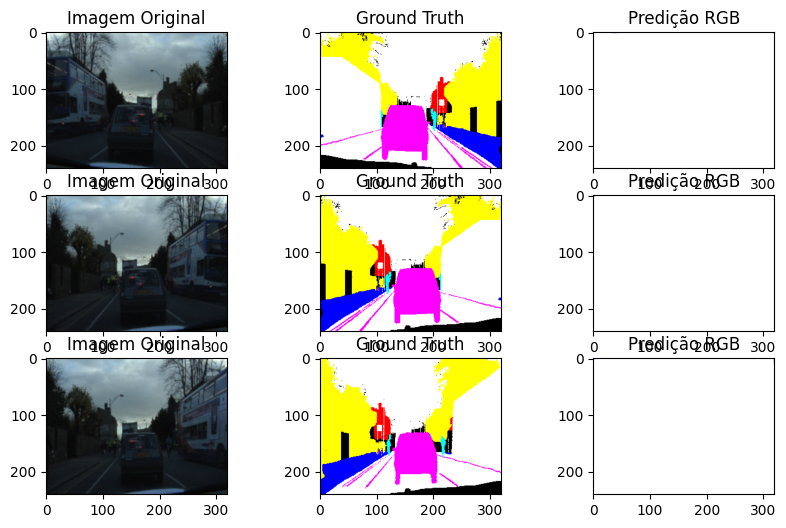

Epoch [2/25], Loss: 1.3047, Accuracy: 66.92%
Validation Loss: 1.4687, Validation Accuracy: 55.93%
Epoch [3/25], Loss: 1.0924, Accuracy: 71.06%
Validation Loss: 1.0913, Validation Accuracy: 69.79%
Epoch [4/25], Loss: 0.9955, Accuracy: 73.26%
Validation Loss: 1.1547, Validation Accuracy: 66.68%
Epoch [5/25], Loss: 0.8840, Accuracy: 75.92%
Validation Loss: 0.8842, Validation Accuracy: 75.71%
Epoch [6/25], Loss: 0.8070, Accuracy: 77.76%
Validation Loss: 0.7750, Validation Accuracy: 78.80%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].


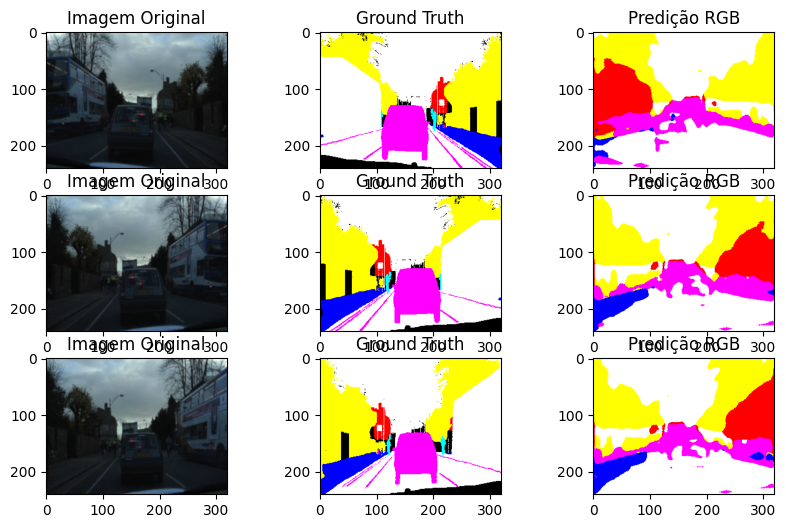

Epoch [7/25], Loss: 0.7711, Accuracy: 78.39%
Validation Loss: 1.2414, Validation Accuracy: 66.18%
Epoch [8/25], Loss: 0.7543, Accuracy: 78.71%
Validation Loss: 0.7662, Validation Accuracy: 78.40%
Epoch [9/25], Loss: 0.7232, Accuracy: 79.53%
Validation Loss: 0.8492, Validation Accuracy: 75.97%
Epoch [10/25], Loss: 0.6952, Accuracy: 80.21%
Validation Loss: 0.7387, Validation Accuracy: 79.46%
Epoch [11/25], Loss: 0.6562, Accuracy: 81.23%
Validation Loss: 0.7853, Validation Accuracy: 76.66%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].


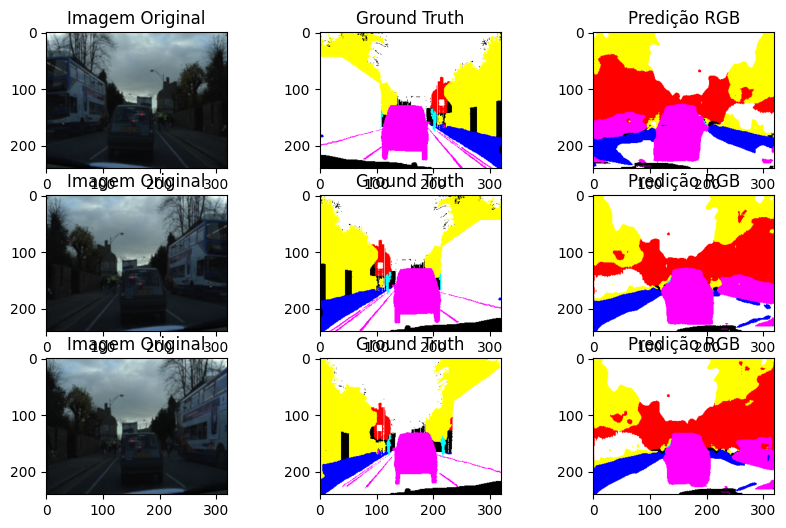

Epoch [12/25], Loss: 0.6436, Accuracy: 81.62%
Validation Loss: 0.6696, Validation Accuracy: 81.08%
Epoch [13/25], Loss: 0.6172, Accuracy: 82.19%
Validation Loss: 0.6673, Validation Accuracy: 81.29%
Epoch [14/25], Loss: 0.6023, Accuracy: 82.53%
Validation Loss: 0.9060, Validation Accuracy: 72.07%
Epoch [15/25], Loss: 0.5798, Accuracy: 83.05%
Validation Loss: 0.6440, Validation Accuracy: 81.96%
Epoch [16/25], Loss: 0.5722, Accuracy: 83.22%
Validation Loss: 0.6710, Validation Accuracy: 80.34%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].


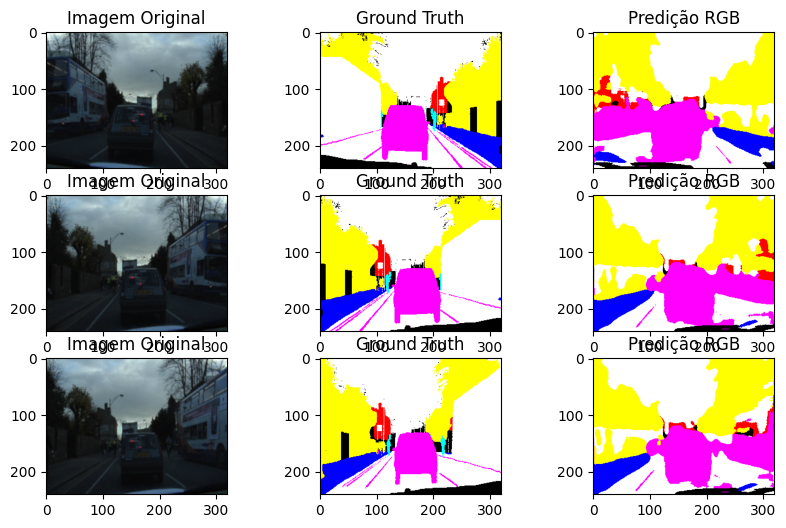

Epoch [17/25], Loss: 0.5561, Accuracy: 83.67%
Validation Loss: 0.6987, Validation Accuracy: 80.33%
Epoch [18/25], Loss: 0.5721, Accuracy: 83.23%
Validation Loss: 0.6348, Validation Accuracy: 81.90%
Epoch [19/25], Loss: 0.5600, Accuracy: 83.43%
Validation Loss: 0.7118, Validation Accuracy: 79.37%
Epoch [20/25], Loss: 0.5535, Accuracy: 83.53%
Validation Loss: 0.5914, Validation Accuracy: 82.71%
Epoch [21/25], Loss: 0.5179, Accuracy: 84.60%
Validation Loss: 0.5833, Validation Accuracy: 83.12%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..192.0].


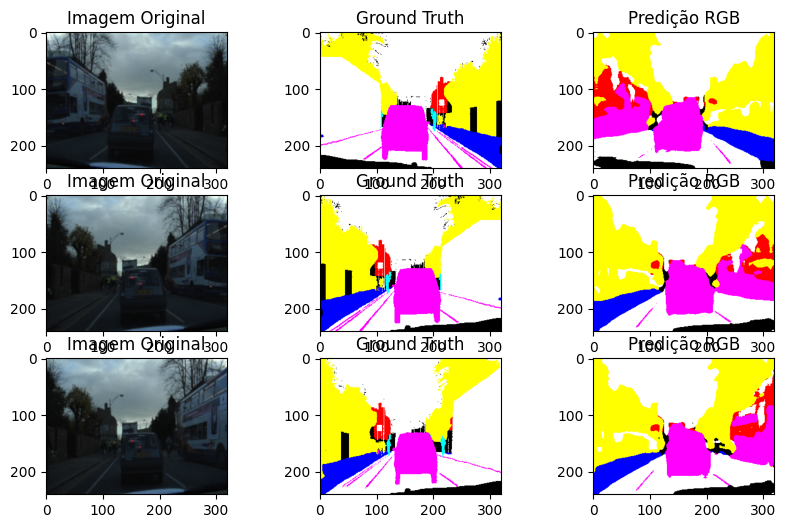

Epoch [22/25], Loss: 0.5048, Accuracy: 84.84%
Validation Loss: 1.2524, Validation Accuracy: 68.80%
Epoch [23/25], Loss: 0.4883, Accuracy: 85.16%
Validation Loss: 0.5497, Validation Accuracy: 84.10%
Epoch [24/25], Loss: 0.4934, Accuracy: 85.06%
Validation Loss: 0.5672, Validation Accuracy: 83.32%
Epoch [25/25], Loss: 0.4886, Accuracy: 85.16%
Validation Loss: 0.5258, Validation Accuracy: 84.68%


{'train_loss': [2.1468872708432816,
  1.3046601975665373,
  1.092350637211519,
  0.9954669896294089,
  0.8839979382122264,
  0.8069900677484625,
  0.7711030051988714,
  0.7543396213475395,
  0.7231756571461173,
  0.6951845375930562,
  0.6562260739943561,
  0.6436006847549888,
  0.6171757561319015,
  0.6022730382049785,
  0.5798490205231834,
  0.5721942019813201,
  0.556148961186409,
  0.5720722947050544,
  0.5599653957521215,
  0.5535226963898715,
  0.5179181616095936,
  0.5048227397834554,
  0.48829325069399443,
  0.4934384770253125,
  0.4885778348235523],
 'val_loss': [2.2604186269972057,
  1.4686864879396226,
  1.0913439724180434,
  1.154668264918857,
  0.8842284811867608,
  0.774979935752021,
  1.2414249645339117,
  0.7662400073475308,
  0.8492165936364068,
  0.7387211124102274,
  0.7853062881363763,
  0.6695881883303324,
  0.6673380633195242,
  0.906034572256936,
  0.6439513431655036,
  0.6710380183325874,
  0.6987210313479105,
  0.634814225965076,
  0.7118188672595553,
  0.591431

In [10]:
# Exemplo de uso
image_dim = (3, 240, 320)
n_channels = 64
n_classes = 32

# Verificar se a GPU está disponível e usar o dispositivo adequado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo em uso: {device}")

# Definir o modelo
model = UNet(image_dim=image_dim, n_channels=n_channels, n_classes=n_classes)

# Função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Carregar os DataLoaders (substitua pelos seus datasets reais)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Carregar o dicionário de classes
dir_dataset = "data/CamVid"  # Verifique o caminho correto para seu dataset
class_dict_path = os.path.join(dir_dataset, 'class_dict.csv')
class_dict = pd.read_csv(class_dict_path)

# Gerar os dicionários de mapeamento
rgb_to_index, index_to_label = dict_labels(class_dict)

# Instanciar a classe de treinamento
trainer = UNetTrainer(model, train_loader, val_loader, test_loader, rgb_to_index, index_to_label, optimizer, criterion, device=device)

# Treinar o modelo por 25 épocas
trainer.train(num_epochs=25)
